In [1]:
%matplotlib inline

## [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso)
- Estimates **sparse coefficients**.
- Especially useful for **compressed sensing**.
- Loss function: $\min_{w} { \frac{1}{2n_{\text{samples}}} ||X w - y||_2 ^ 2 + \alpha ||w||_1}$
    - where $\alpha$ is a constant,
    - $||w||_1$ is the l1 norm of the cofficients.
- Uses **coordinate descent** to fit the coefficients.
- Uses [lasso path](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.lasso_path.html#sklearn.linear_model.lasso_path) as a internal function to compute the cofficients.

In [2]:
from sklearn import linear_model

clf = linear_model.Lasso(alpha=0.1)
clf.fit([[0,0], [1, 1], [2, 2]], [0, 1, 2])

print(clf.coef_, clf.intercept_)

[0.85 0.  ] 0.15000000000000002


## Example: Tomography reconstruction (Lasso, Ridge)
- Task: reconstruct an image from a set of parallel projections from different angles.
- Without any knowledge, the #projections required is ~L (image size in pixels)
- For simplicity we use a sparse image with non-zero pixels on the object boundaries.
- Reconstruction with L1 penalty returns results with zero error (all pixels successfully labeled as 0 or 1), even with added noise.
- Reconstruction with L2 penalty (Ridge) returns many pixel label errors, which appear in the image.

In [3]:
import numpy as np
from scipy import sparse
from scipy import ndimage
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

In [4]:
def _weights(x, dx=1, orig=0):
    x       = np.ravel(x)
    floor_x = np.floor((x - orig) / dx).astype(np.int64)
    alpha   = (x - orig - floor_x * dx) / dx
    return np.hstack((floor_x, floor_x + 1)), np.hstack((1 - alpha, alpha)),

In [5]:
def _generate_center_coordinates(l_x):
    X, Y   = np.mgrid[:l_x, :l_x].astype(np.float64)
    center = l_x / 2.
    X     += 0.5 - center
    Y     += 0.5 - center
    return X, Y

In [6]:
# build tomography design matrix
# l_x (int): linear size of image array
# n_dir (int): #angles at which projections are acquired
# p (sparse matrix of shape (n_dir l_x, l_x**2))
#

def build_projection_operator(l_x, n_dir):

    X, Y   = _generate_center_coordinates(l_x)
    angles = np.linspace(0, np.pi, n_dir, endpoint=False)
    data_inds, weights, camera_inds = [], [], []
    data_unravel_indices = np.arange(l_x ** 2)
    data_unravel_indices = np.hstack((data_unravel_indices,
                                      data_unravel_indices))
    
    for i, angle in enumerate(angles):
        Xrot         = np.cos(angle) * X - np.sin(angle) * Y
        inds, w      = _weights(Xrot, dx=1, orig=X.min())
        mask         = np.logical_and(inds >= 0, inds < l_x)
        weights     += list(w[mask])
        camera_inds += list(inds[mask] + i * l_x)
        data_inds   += list(data_unravel_indices[mask])

    proj_operator = sparse.coo_matrix(
        (weights, (camera_inds, data_inds)))
    return proj_operator

In [7]:
def generate_synthetic_data():
    rs         = np.random.RandomState(0)
    n_pts      = 36
    x, y       = np.ogrid[0:l, 0:l]
    mask_outer = (x - l / 2.) ** 2 + (y - l / 2.) ** 2 < (l / 2.) ** 2
    mask       = np.zeros((l, l))
    points     = l * rs.rand(2, n_pts)

    mask[
        (points[0]).astype(np.int), 
        (points[1]).astype(np.int)] = 1
    
    mask = ndimage.gaussian_filter(
        mask, 
        sigma = l/n_pts)
    res  = np.logical_and(
        mask > mask.mean(), 
        mask_outer)
    return np.logical_xor(res, ndimage.binary_erosion(res))

In [8]:
# Generate synthetic images & projections
l             = 128
proj_operator = build_projection_operator(l, l // 7)
data          = generate_synthetic_data()
proj          = proj_operator * data.ravel()[:, np.newaxis]
proj         += 0.15 * np.random.randn(*proj.shape)

In [9]:
# Reconstruction with L2 (Ridge) penalization
rgr_ridge = Ridge(alpha=0.2)
rgr_ridge.fit(proj_operator, proj.ravel())
rec_l2 = rgr_ridge.coef_.reshape(l, l)

In [10]:
# Reconstruction with L1 (Lasso) penalty
# alpha found via cross validation
rgr_lasso = Lasso(alpha=0.001)
rgr_lasso.fit(proj_operator, proj.ravel())
rec_l1 = rgr_lasso.coef_.reshape(l, l)

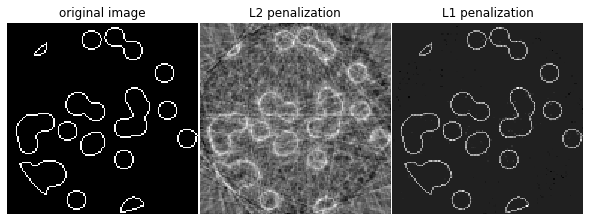

In [11]:
plt.figure(figsize=(8, 3.3))

plt.subplot(131)
plt.imshow(data, cmap=plt.cm.gray, interpolation='nearest')
plt.axis('off')
plt.title('original image')

plt.subplot(132)
plt.imshow(rec_l2, cmap=plt.cm.gray, interpolation='nearest')
plt.title('L2 penalization')
plt.axis('off')

plt.subplot(133)
plt.imshow(rec_l1, cmap=plt.cm.gray, interpolation='nearest')
plt.title('L1 penalization')
plt.axis('off')

plt.subplots_adjust(
    hspace=0.01, wspace=0.01, top=1, bottom=0, left=0, right=1)

plt.show()

## [Lasso & Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html#l1-feature-selection)
- Because Lasso returns a sparse model, it can be used for feature selection.

## [Multiple-Regression Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.MultiTaskLasso.html#sklearn.linear_model.MultiTaskLasso)
- Estimates sparse coefficients, simulataneously, for multiple regression problems (tasks).
- **y**: a 2D array of (#samples, #tasks). Each task must have the same #features.
- It uses a mixed L1L2 norm for regularization.
- The loss function: $\min_{w} { \frac{1}{2n_{\text{samples}}} ||X W - Y||_{\text{Fro}} ^ 2 + \alpha ||W||_{21}}$
- $\text{Fro}$ is the Frobenius norm: $||A||_{\text{Fro}} = \sqrt{\sum_{ij} a_{ij}^2}$
- The L1L2 norm: $||A||_{2 1} = \sum_i \sqrt{\sum_j a_{ij}^2}.$
- Uses coordinate descent to fit the coefficients.

- Example: Simulate multiple time series functions. Multi-task Lasso imposes features selected at one time point are selected for all time points. This makes Lasso-based feature selection more stable.

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import MultiTaskLasso, Lasso

In [13]:
# Generate 2D coefficients with sine waves & random frequency & phase

rng = np.random.RandomState(42)

n_samples, n_features, n_tasks, n_relevant_features = 100, 30, 40, 5

coef  = np.zeros((n_tasks, n_features))
times = np.linspace(0, 2 * np.pi, n_tasks)

for k in range(n_relevant_features):
    coef[:, k] = np.sin(
        (1. + rng.randn(1)) * times + 3 * rng.randn(1))

X = rng.randn(n_samples, n_features)
Y = np.dot(X, coef.T) + rng.randn(n_samples, n_tasks)

In [14]:
coef_lasso_ = np.array(
    [Lasso(alpha=0.5).fit(X, y).coef_ for y in Y.T])

coef_multi_task_lasso_ = MultiTaskLasso(
    alpha=1.).fit(X, Y).coef_

Text(0.5, 0.98, 'Coefficient non-zero location')

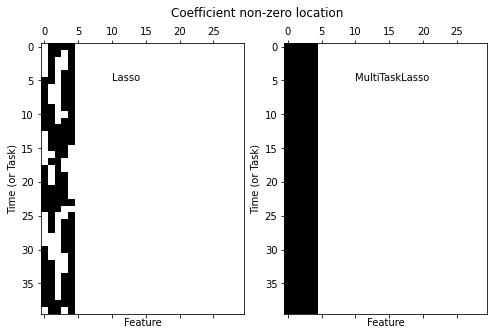

In [15]:
# sparsity pattern of a 2D array

fig = plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.spy(coef_lasso_)
plt.xlabel('Feature')
plt.ylabel('Time (or Task)')
plt.text(10, 5, 'Lasso')

plt.subplot(1, 2, 2)
plt.spy(coef_multi_task_lasso_)
plt.xlabel('Feature')
plt.ylabel('Time (or Task)')
plt.text(10, 5, 'MultiTaskLasso')
fig.suptitle('Coefficient non-zero location')

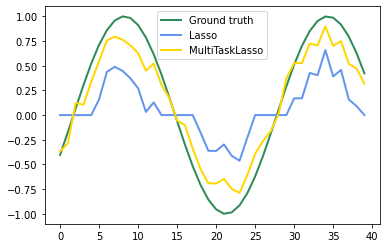

In [16]:
feature_to_plot = 0
plt.figure()
lw = 2
plt.plot(
    coef[:, feature_to_plot], 
    color='seagreen', 
    linewidth=lw,
    label='Ground truth')

plt.plot(
    coef_lasso_[:, feature_to_plot], 
    color='cornflowerblue', 
    linewidth=lw,
    label='Lasso')

plt.plot(
    coef_multi_task_lasso_[:, feature_to_plot], 
    color='gold', 
    linewidth=lw,
    label='MultiTaskLasso')

plt.legend(loc='upper center')
plt.axis('tight')
plt.ylim([-1.1, 1.1])
plt.show()